### **Importing stuff:**

In [118]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Open Data from Kaggel
%pip install -q opendatasets
import opendatasets as od
import os
import opendatasets as od
import os

# TensorFlow
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.


In [119]:
# insert ypu kaggle  username and key
od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small',data_dir="dataset")

Skipping, found downloaded files in "dataset\fashion-product-images-small" (use force=True to force download)


In [120]:
df_data = pd.read_csv("dataset/fashion-product-images-small/styles.csv", on_bad_lines='skip')
image_files = os.listdir("dataset/fashion-product-images-small/images")

## **Data preparation**

**Cleaning of dataset:**

In [121]:
df_data.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [122]:
df_data.dropna(inplace=True)

#check if file exists
df_data['file_found'] = df_data['id'].apply(lambda x: f"{x}.jpg" in image_files)

df_data['file_found'].value_counts()

mask = df_data['file_found']
df_data = df_data[mask].reset_index(drop=True)

In [123]:
df_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,True


**Deciding the labels for the Dataset:**

In [124]:
#see what is goning on with the labels
cat_columns = ['gender', 'masterCategory', 'subCategory', 'articleType','baseColour', 'season', 'year', 'usage']

for col in cat_columns:
    print(col)
    print(df_data[col].unique())
    print('-------------------------')

gender
['Men' 'Women' 'Boys' 'Girls' 'Unisex']
-------------------------
masterCategory
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
-------------------------
subCategory
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
-------------------------
articleType
['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lips

**Remove categories with less than 500 or 1000 entries respectively**

In [125]:
#removing all labels below 500 items
value_counts = df_data['articleType'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <500:
        break

types_used = indexes[:i]
print('Article types used: ',types_used)

Article types used:  Index(['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes',
       'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses', 'Wallets',
       'Flip Flops', 'Sandals', 'Briefs', 'Belts', 'Backpacks', 'Socks',
       'Formal Shoes', 'Perfume and Body Mist', 'Jeans', 'Shorts', 'Trousers',
       'Flats'],
      dtype='object', name='articleType')


In [126]:
value_counts = df_data['baseColour'].value_counts()
indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

colours_used = indexes[:i]
print('Base Colours used: ',colours_used)

Base Colours used:  Index(['Black', 'White', 'Blue', 'Brown', 'Grey', 'Red', 'Green', 'Pink',
       'Navy Blue', 'Purple', 'Silver'],
      dtype='object', name='baseColour')


In [127]:
value_counts = df_data['subCategory'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

subCategory_used = indexes[:i]
print('sub Category used: ',subCategory_used)

sub Category used:  Index(['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches', 'Innerwear',
       'Jewellery', 'Eyewear', 'Fragrance'],
      dtype='object', name='subCategory')


In [128]:
df_data = df_data[df_data['articleType'].isin(types_used)]
df_data = df_data[df_data['baseColour'].isin(colours_used)]
df_data = df_data[df_data['subCategory'].isin(subCategory_used)]

In [129]:
#Drop unnecessary colums
df_data.drop(['gender', 'masterCategory','season', 'year', 'usage', 'productDisplayName'], axis=1, inplace=True)

In [130]:
df_data.head()

,id,subCategory,articleType,baseColour,file_found
0,15970,Topwear,Shirts,Navy Blue,True
1,39386,Bottomwear,Jeans,Blue,True
2,59263,Watches,Watches,Silver,True
4,53759,Topwear,Tshirts,Grey,True
5,1855,Topwear,Tshirts,Grey,True


In [131]:
df_data.describe()

,id
count,26136.000000
mean,25871.864210
std,16272.013115
min,1163.000000
25%,11397.500000
50%,24097.500000
75%,39168.250000
max,60000.000000


**Append images:**

In [132]:
# insert ypu kaggle  username and key
df_data['filename'] = df_data['id'].apply(lambda x: os.path.join("dataset/fashion-product-images-small/images/",str(x)+".jpg"))
df_data.head()

,id,subCategory,articleType,baseColour,file_found,filename
0,15970,Topwear,Shirts,Navy Blue,True,dataset/fashion-product-images-small/images/15...
1,39386,Bottomwear,Jeans,Blue,True,dataset/fashion-product-images-small/images/39...
2,59263,Watches,Watches,Silver,True,dataset/fashion-product-images-small/images/59...
4,53759,Topwear,Tshirts,Grey,True,dataset/fashion-product-images-small/images/53...
5,1855,Topwear,Tshirts,Grey,True,dataset/fashion-product-images-small/images/18...


**We use only 2000 entries for training for proof of concept. Because training an model with more entries takes significantly more time and often exceeds free resources on google colab**
<br>
**The model trained on a small dataset shows also the decent results**

In [133]:
df_data = df_data.sample(n=2000, random_state=0)

In [134]:
df_data.head()

,id,subCategory,articleType,baseColour,file_found,filename
3130,9462,Topwear,Shirts,White,True,dataset/fashion-product-images-small/images/94...
15917,36655,Bags,Handbags,Black,True,dataset/fashion-product-images-small/images/36...
26587,32930,Topwear,Shirts,Black,True,dataset/fashion-product-images-small/images/32...
12759,12607,Topwear,Tops,Purple,True,dataset/fashion-product-images-small/images/12...
31540,41745,Topwear,Tshirts,White,True,dataset/fashion-product-images-small/images/41...


### **Building the model**

In [135]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_path = df_data['filename'][3130]
image = load_img(image_path)
image = img_to_array(image)
image.shape

(80, 60, 3)

**Normalize images by fixing width and height**
<br>
**this also helps model to train faster**

In [136]:
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 60

In [137]:
def process_image(image_path):
    image = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT,3))
    image = img_to_array(image)
    return image

In [138]:
def append_images(column):
    images = []
    for file_path in column:
        images.append(process_image(file_path))
    return np.array(images)

**Splitting and definition of output categories:**

In [139]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

**We choose only 3 categories from the dataset for the model to classify**

In [140]:
output_labels = ["subCategory","articleType","baseColour"]

In [141]:
(X_filepath_train, X_filepath_test,
 y_train,y_test) = train_test_split(df_data["filename"],df_data[output_labels],
                                                    test_size=0.2, random_state=42)

In [142]:
X_train = append_images(X_filepath_train)
X_test = append_images(X_filepath_test)

In [143]:
y_train.head()

,subCategory,articleType,baseColour
18884,Topwear,Tshirts,Green
739,Watches,Watches,Black
41170,Topwear,Shirts,White
10519,Bottomwear,Shorts,Black
12896,Watches,Watches,White


In [144]:
y_test.head()

,subCategory,articleType,baseColour
18362,Topwear,Shirts,Pink
8654,Topwear,Tshirts,Red
32813,Shoes,Formal Shoes,Black
40448,Watches,Watches,White
9780,Topwear,Shirts,Blue


**Create the encoders for labels. We save them to use later to decode the outputs of the model**

In [145]:
label_encoders = {}
data_train = {}
data_test = {}

In [146]:
for label in output_labels:
    label_encoder = LabelBinarizer()
    encoded_data_train = label_encoder.fit_transform(y_train[label].to_numpy())
    encoded_data_test = label_encoder.transform(y_test[label].to_numpy())

    label_encoders[label] = label_encoder
    data_train[label] = encoded_data_train
    data_test[label] = encoded_data_test

**The model:**

In [147]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense,BatchNormalization, MaxPooling2D, Conv2D, Activation, Input, Flatten,Dropout)

In [148]:
img_inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = Conv2D(32, 3, padding='same', activation='relu')(img_inputs)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

In [149]:
def make_branch(res_input, n_out, name):
    x = Dense(256, activation='relu')(res_input)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(n_out)(x)
    x = Activation("softmax",name=name)(x)
    return x

In [150]:
branches = {}

In [151]:
for label in output_labels:
    branches[label] = make_branch(x, len(label_encoders[label].classes_),label)

In [152]:
model = Model(inputs=img_inputs,outputs=branches)

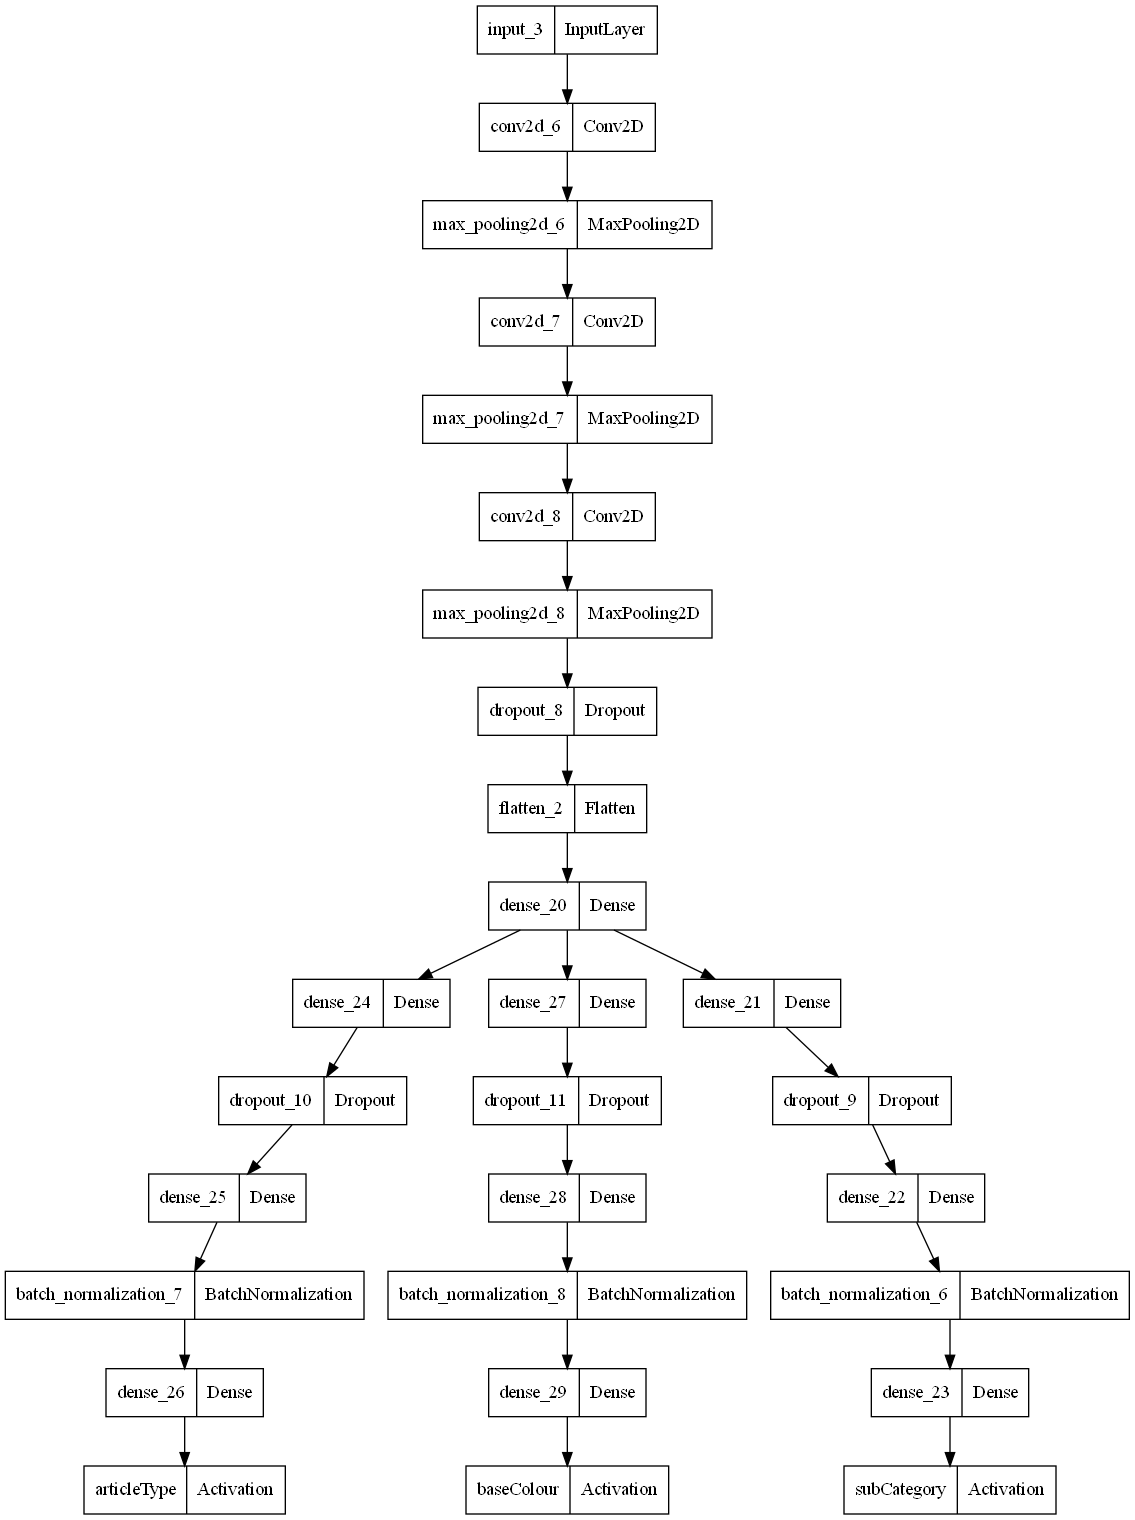

In [153]:
keras.utils.plot_model(model)

**For reproducibility and time saving we can open the trained model and reuse it** 

In [176]:
TRAIN_MODEL = False

In [155]:
if(TRAIN_MODEL):
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")
    EPOCHS=40
    history = model.fit(
        X_train,
        data_train,
        epochs=EPOCHS,
        verbose=1
    )

In [156]:
if(TRAIN_MODEL):
    history_df = pd.DataFrame(history.history)
    history_df.loc[:,[col for col in history_df.columns if 'accuracy' in col and 'val' not in col]].plot()
    history_df.loc[:,[col for col in history_df.columns if 'loss' in col and 'val' not in col]].plot()

In [157]:
if(TRAIN_MODEL): 
    model.save('group1_02.keras')
    # Get the absolute path of the saved model file
    model_path = os.path.abspath('group1_02.keras')
    print(f"The saved model is located at: {model_path}")   
else:
    # Load the model
    model = tf.keras.models.load_model('group1_02.keras')

## Evaluate model Accuracy

**Evaluete the model accuracy on the test dataset**

In [158]:
outputs = model.predict(X_test)

13/13 [==============================] - 0s 16ms/step


In [159]:
predictions = {}
accuracies = {}

In [160]:
for label in output_labels:
    predictions[label] = label_encoders[label].classes_[outputs[label].argmax(axis=1)]

In [161]:
from sklearn.metrics import accuracy_score

In [162]:
for label in output_labels:
    accuracies[label] = accuracy_score(y_test[label],predictions[label])

In [163]:
for label in output_labels:
    print(
        "This model has accuracy of {:.2f}% for the label {}.".format(accuracies[label]*100,label)
    )

This model has accuracy of 98.25% for the label subCategory.
This model has accuracy of 81.50% for the label articleType.
This model has accuracy of 62.50% for the label baseColour.


# Test on some images

**We test the model on two images from the internet that are not present in the dataset**
<br>
**To make it even more interesting the images of ties were not presen in the dataset at all. Thus the model shows funny results**
<br>
***Disclaimer***: **Retraing the model and altering the dataset may change the prediction output below. Its strongly the case for the tie image. Because this category is not present in the dataset at all**

### define functions

In [164]:
import math

In [165]:
def classify_image(output_values,image_path):
    image = load_img(image_path)
    plt.imshow(image, interpolation='nearest')
    plt.show()
    for label in output_labels:
        print(
            "This items {} is most likely {}. With a {:.2f} percent confidence."
            .format(label,label_encoders[label].classes_[output_values[label].argmax()], 100 * output_values[label].max())
        )

In [166]:
def show_second_color_prpability(output_values):
    #second color prpability
    # Get the index of the highest confidence prediction
    highest_index = output_values[label].argmax()

    # Get the second highest confidence prediction (excluding the highest one)
    second_highest_index = output_values[label].argsort()[-2]

    # Retrieve the class names corresponding to the indices
    highest_label = label_encoders[label].classes_[highest_index]
    second_highest_label = label_encoders[label].classes_[second_highest_index]

    # Calculate the confidence percentages
    highest_confidence = 100 * output_values[label][highest_index]
    second_highest_confidence = 100 * output_values[label][second_highest_index]

    # Display the results
    print("This item {} is most likely {}. With a {:.2f}% confidence."
        " The second most likely label is {} with a {:.2f}% confidence."
        .format(label, highest_label, highest_confidence, second_highest_label, second_highest_confidence))

In [167]:
def show_similar_images(output_values):
    predictions = {}
    for label in output_labels:
        predictions[label] = label_encoders[label].classes_[output_values[label].argmax(axis=0)]

    print("prediction: {}".format(predictions))

    query_mask = ""
    for label in output_labels:
        query_mask += str(label + " == '" + predictions[label] + "' & ")
    query_mask = query_mask[:-3]
    suggested_images = df_data.query(query_mask)

    #return if no similar itemst found
    if(len(suggested_images) == 0):
        print("No similar items found")
        return
    
    #reset index to make next for loop easier
    suggested_images = suggested_images.reset_index(drop=True)

    n_col = 4
    n_row = math.ceil(len(suggested_images)/n_col)
    fig, axs = plt.subplots(nrows=n_row, ncols=n_col,figsize=(n_row*3,10))

    axes_list = axs.ravel()

    for index, row in suggested_images.iterrows():
        image = load_img(row["filename"])
        axes_list[index].imshow(image, interpolation='nearest')
        axes_list[index].set_xticks([])
        axes_list[index].set_yticks([])

    plt.show()

### Image 1: a Tie

In [168]:
image_path_tie = 'tie1_720.jpg'
input_image_tie = np.expand_dims(process_image(image_path_tie), axis=0)

output_tie = model.predict(input_image_tie)

for label in output_labels:
    output_tie[label] = output_tie[label][0]

1/1 [==============================] - 0s 29ms/step


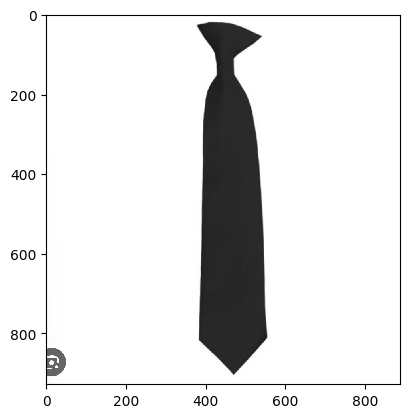

This items subCategory is most likely Fragrance. With a 99.98 percent confidence.
This items articleType is most likely Perfume and Body Mist. With a 96.79 percent confidence.
This items baseColour is most likely Black. With a 98.92 percent confidence.


In [169]:
classify_image(output_tie,image_path_tie)

In [170]:
show_second_color_prpability(output_tie)

This item baseColour is most likely Black. With a 98.92% confidence. The second most likely label is Brown with a 0.82% confidence.


prediction: {'subCategory': 'Fragrance', 'articleType': 'Perfume and Body Mist', 'baseColour': 'Black'}


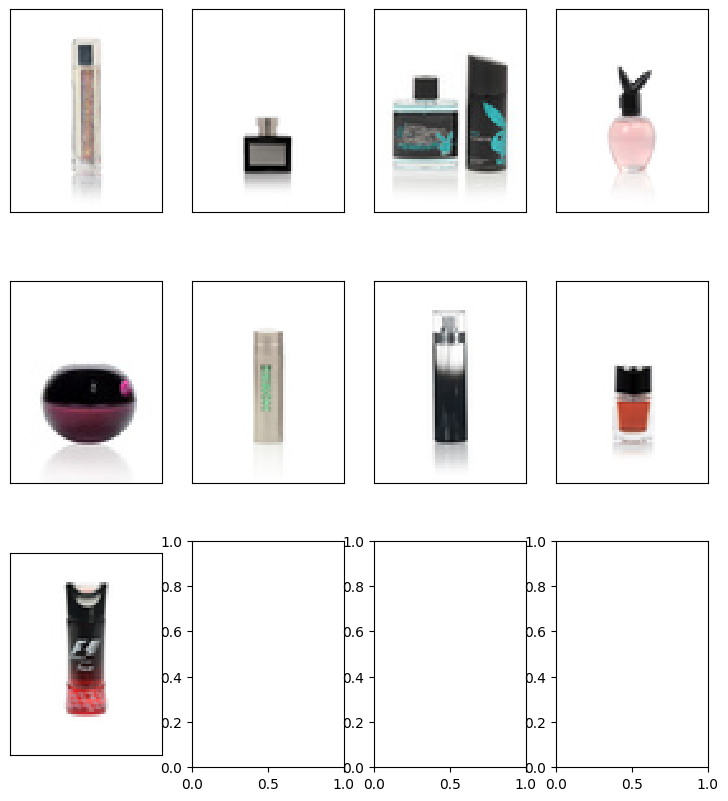

In [171]:
show_similar_images(output_tie)

### Image 2: a Shoe

In [172]:
image_path_shoe = 'shoe.jpg'
input_image_shoe = np.expand_dims(process_image(image_path_shoe), axis=0)

output_shoe = model.predict(input_image_shoe)                                        

for label in output_labels:
    output_shoe[label] = output_shoe[label][0]

1/1 [==============================] - 0s 31ms/step


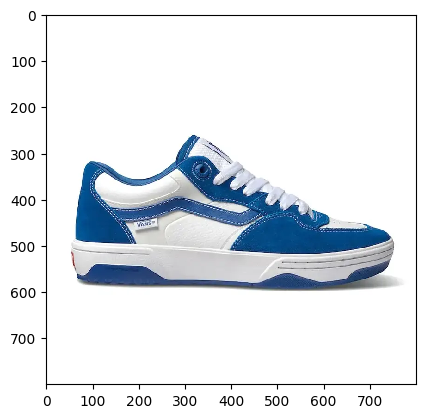

This items subCategory is most likely Shoes. With a 100.00 percent confidence.
This items articleType is most likely Casual Shoes. With a 94.30 percent confidence.
This items baseColour is most likely Blue. With a 99.92 percent confidence.


In [173]:
classify_image(output_shoe,image_path_shoe)

In [174]:
show_second_color_prpability(output_shoe)

This item baseColour is most likely Blue. With a 99.92% confidence. The second most likely label is Navy Blue with a 0.04% confidence.


prediction: {'subCategory': 'Shoes', 'articleType': 'Casual Shoes', 'baseColour': 'Blue'}


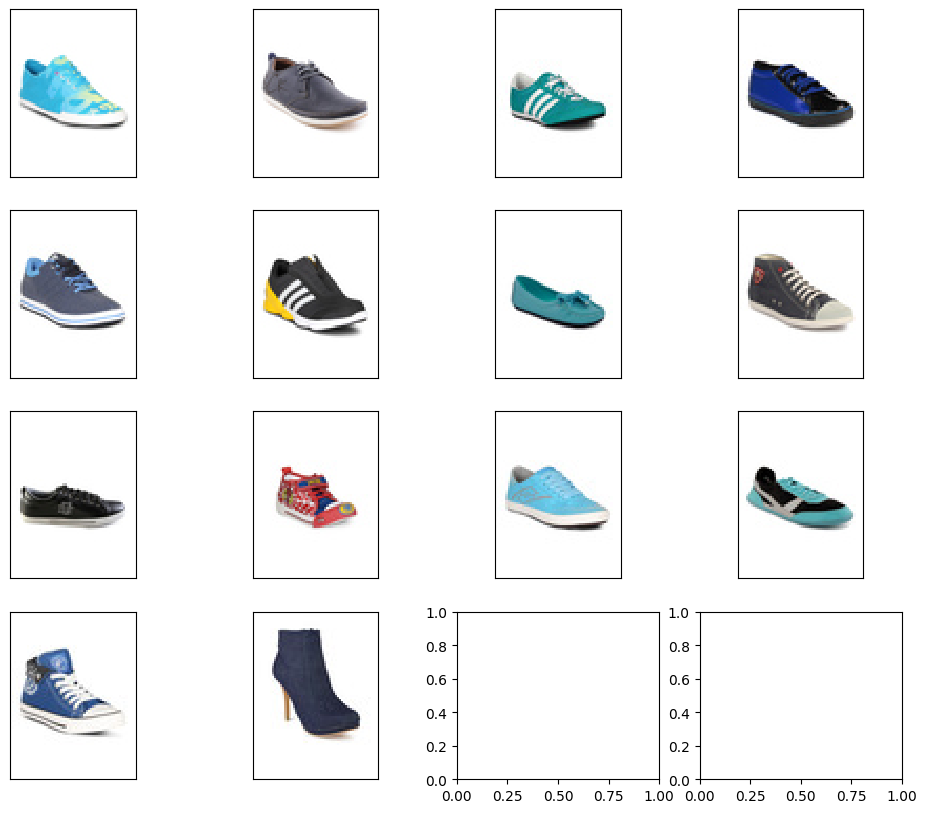

In [175]:
show_similar_images(output_shoe)